In [1]:
from skimage import io
img_array = io.imread("./images/test img.jpg")

In [2]:
img_array.shape

(480, 704, 3)

In [4]:
!pip install matplotlib


     |████████████████████████████████| 7.3 MB 463 kB/s eta 0:00:01
     |████████████████████████████████| 895 kB 414 kB/s eta 0:00:01
     |████████████████████████████████| 61 kB 50 kB/s  eta 0:00:01


In [5]:
import matplotlib.pyplot as plt

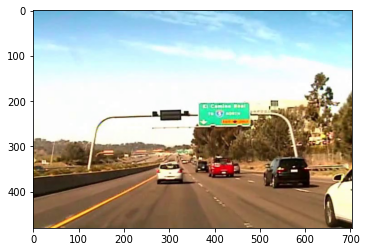

In [6]:
plt.figure()
plt.imshow(img_array)
plt.show()


In [7]:
from torchvision import transforms
import PIL
import copy

In [8]:
from torchvision import transforms
import PIL
import copy


composed = transforms.Compose(
    [transforms.Resize((256, 256)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


def plot_img_from_normalized_img(img_array, is_normalized=True):
    img_to_be_plotted = copy.deepcopy(img_array)
    assert len(img_array.shape) == 3
    if img_to_be_plotted.shape[0] == 3:
        img_to_be_plotted = img_to_be_plotted.transpose(1, 2, 0)
    if is_normalized:
        for idx, (m, v) in enumerate(zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])):
            img_to_be_plotted[:, :, idx] = (img_to_be_plotted[:, :, idx] * v) + m
    plt.figure()
    plt.imshow(img_to_be_plotted)
    plt.show()

In [9]:
transformed_img = composed(PIL.Image.fromarray(img_array))

In [10]:
transformed_img.shape

torch.Size([3, 256, 256])

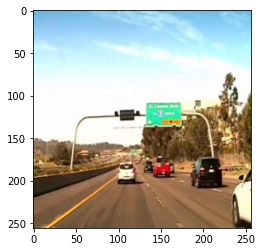

In [11]:
plot_img_from_normalized_img(transformed_img.detach().numpy())

In [12]:
import json

with open("../imagenet_class_index.json") as json_file:
    class_idx = json.load(json_file)

idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

FileNotFoundError: [Errno 2] No such file or directory: '../imagenet_class_index.json'

Model Definition 


In [14]:
import torchvision.models as models
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [15]:
class ImageDot(nn.Module):
    """
    Class to treat an image with translucent color dots.
    forward method creates a blended image of base and color dots.
    Center positions and colors are hard-coded.
    """
    def __init__(self):
        super(ImageDot, self).__init__()
        self.means = [0.485, 0.456, 0.406]
        self.stds = [0.229, 0.224, 0.225]
        self.alpha = 0.9
        self.radius = 25.0
        self.beta = 2.0
        self.center = nn.Parameter(torch.tensor([
            [0.25, 0.25], [0.25, 0.5], [0.25, 0.75],
            [0.5, 0.25], [0.5, 0.5], [0.5, 0.75],
            [0.75, 0.25], [0.75, 0.5], [0.75, 0.75]]),
            requires_grad=True)
        self.color = nn.Parameter(torch.tensor([
            [0.5, 0.5, 0.5], [0.5, 0.5, 0.5], [0.5, 0.5, 0.5],
            [0.5, 0.5, 0.5], [0.5, 0.5, 0.5], [0.5, 0.5, 0.5],
            [0.5, 0.5, 0.5], [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]]),
            requires_grad=True)

    def forward(self, x):
        _, _, height, width = x.shape
        blended = x
        for idx in range(self.center.shape[0]):
            mask = self._create_circle_mask(height, width,
                                            self.center[idx] * 255.0, self.beta)
            normalized_color = self._normalize_color(self.color[idx],
                                                     self.means, self.stds)
            blended = self._create_blended_img(blended, mask, normalized_color)
        return blended

    def _normalize_color(self, color, means, stds):
        return list(map(lambda x, m, s: (x - m) / s, color, means, stds))

    def _create_circle_mask(self, height, width, center, beta):
        hv, wv = torch.meshgrid([torch.arange(0, height), torch.arange(0, width)])
        hv, wv = hv.type(torch.FloatTensor), wv.type(torch.FloatTensor)
        d = ((hv - center[0]) ** 2 + (wv - center[1]) ** 2) / self.radius ** 2
        return torch.exp(- d ** beta + 1e-10)

    def _create_blended_img(self, base, mask, color):
        alpha_tile = self.alpha * mask.expand(3, mask.shape[0], mask.shape[1])
        color_tile = torch.zeros_like(base)
        for c in range(3):
            color_tile[:, c, :, :] = color[c]
        return (1. - alpha_tile) * base + alpha_tile * color_tile


class AttackModel(nn.Module):
    """
    Class to create an adversarial example.
    forward method returns the prediction result of the perturbated image.
    """
    def __init__(self):
        super(AttackModel, self).__init__()
        self.image_dot = ImageDot()
        self.base_model = models.resnet50(pretrained=True).eval()
        self._freeze_pretrained_model()

    def _freeze_pretrained_model(self):
        for param in self.base_model.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.image_dot(x)
        return self.base_model(x)

In [16]:
torch.manual_seed(0)

In [17]:
model = AttackModel()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/hiwotbelaytadesse/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100.0%


In [18]:
pred = model.base_model(transformed_img.unsqueeze(0))
pred = np.squeeze(pred.detach().numpy())
for elem in np.argsort(pred)[-10:]:
    print(f"class: {idx2label[elem]}, idx: {elem}, logit: {pred[elem]:.4f}")

NameError: name 'idx2label' is not defined

/opt/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1640812107944/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


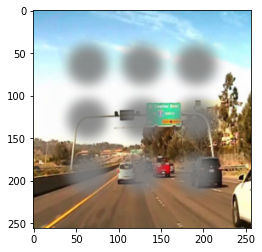

In [19]:
dotted_img = model.image_dot(transformed_img.unsqueeze(0))
plot_img_from_normalized_img(dotted_img.squeeze().detach().numpy())

In [20]:
# 919: street_sign
# 595: harvester

def compute_loss(pred: torch.Tensor, true_label_idx: int, target_label_idx: int,
                 is_targeted: bool) -> torch.Tensor:
    # Targeted: - loss(true_label) + loss(target_label)
    # Non-targeted: - loss(true_label)
    assert true_label_idx is not None
    true_label_contrib = F.nll_loss(pred, torch.tensor([true_label_idx]))
    if is_targeted:
        target_label_contrib = F.nll_loss(pred, torch.tensor([target_label_idx]))
        return torch.mean(- true_label_contrib + target_label_contrib)  # targeted
    else:
        return torch.mean(- true_label_contrib)  # non-targeted

In [24]:
lr = 0.008
loss_function = nn.NLLLoss()

for epoch in range(200):
    if (epoch + 1) % 50 == 0:
        lr *= 0.5
    model.zero_grad()
    pred = model(transformed_img.unsqueeze(0))
#     loss = compute_loss(pred, 919, -1, False)  # Non-targeted
    loss = compute_loss(pred, 919, 595, True)  # Targeted
    loss.backward(retain_graph=True)

    print(f"epoch: {epoch + 1}, loss: {loss.data:.4f}")

    for param in model.parameters():
        if param.requires_grad == True:
            param.data = torch.clamp(param.data - param.grad.data * lr, min=0.0, max=1.0)

epoch: 1, loss: -1.5060


AttributeError: 'NoneType' object has no attribute 'data'